In [1]:
import sys
import numpy as np
import import_ipynb
import pandas as pd
from pathlib import Path
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_processing import matrices_assembly as assembly 
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 3: Problem 3 (p33)

## Physics Constants

In [2]:
OMEGA = 2 * np.pi * 3E8
K0 = OMEGA * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0
print(f'Omega: {OMEGA:.3e} rad/s')
print(f'Wavelength: {WAVELENGTH:.4} m')
print(f'K0^2: {K0**2:.6} 1/m')

Omega: 1.885e+09 rad/s
Wavelength: 0.9993 m
K0^2: 39.5331 1/m


## 3-noded Linear Triangular Elements, $P_1$

In [3]:
FINITE_ELEMENT = ("Triangle", 1)

BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'circular_scatterer'},
            {'tag': 102, 'type': 'Free', 'value': None, 'name': 'free_space'},
            {'tag': 103, 'type': 'Free', 'value': None, 'name': 'outer_pml'},
            {'tag': 104, 'type': 'Free', 'value': None, 'name': 'horizontal_cut_line'}]

MATERIAL = [{'tag': 201, 'name': 'free_space', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 202, 'name': 'pml_xy', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 203, 'name': 'pml_x', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1},
            {'tag': 204, 'name': 'pml_y', 'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

DOMAIN = {'a': {'h': WAVELENGTH/25, 'L': WAVELENGTH*0.5, 'ra': WAVELENGTH*0.5, 'x0': 1.0*WAVELENGTH}}
DOMAIN_KEY = 'a'

# Criar geometria coaxial
mesh_data = ps.create_domain_pml(FINITE_ELEMENT, BOUNDARY, MATERIAL, DOMAIN[DOMAIN_KEY], view_mesh=False)

TAGs das Superfícies Fragmentadas: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Pares (Dim, Tag) dos objetos para conformação:
 [(2, 9), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (1, 37)]
Pares (Dim, Tag) dos objetos conformados:
 [(2, 9), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 7), (2, 8), (2, 10), (2, 11), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29)]
TAGs dos Contornos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
TAGs das Superfícies: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11]
Contorno do espalhador: [12]
Contorno do espaço livre: [2, 5, 9, 10, 11]
Contorno de PML_a: [13, 14, 15, 16]
Contorno de PML_b: [1, 18, 19, 20]
Contorno de PML_c: [6, 21, 22, 23]
Contorno de PML_d: [25, 26, 27, 28]
Contorno de PML_i: [11, 14, 17, 18]
Contorno de PML_ii: [1, 2, 3, 4]
Contorno de PML_ii

## Figure 1: Meshed $\Omega_c$ domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


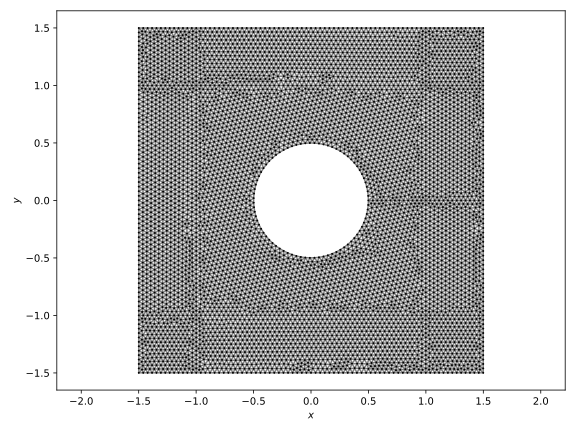

In [4]:
graph.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

## PML Project

In [5]:
# Determinação da Condutividade da PML
R_COEFFICIENT = 1E-4
SIGMA_0X = -np.log(R_COEFFICIENT) / WAVELENGTH

# Dimensões do domínio
x0 = DOMAIN[DOMAIN_KEY]['x0']
n = 1

# Dados da PML
# pml_data = (SIGMA_0X, n, K0, x0)

In [6]:
mesh_data['cell'][1]

{'conn': [847, 870, 836],
 'conn_sorted': [836, 847, 870],
 'conn_edge': None,
 'geo': {'centroid': (-1.0581206474793066, -1.1552723877241382),
  'area': 0.0008477861340625365},
 'contour': {'type': None, 'conn_contour': None},
 'material': {'tag': 202,
  'name': 'pml_xy',
  'relative_magnetic_permeability': 1,
  'relative_electric_permittivity': 1},
 'stiffness_term': [],
 'mass_term': [],
 'source': []}

## FEM Solution

In [7]:
from fem_processing import gaussian_quadrature

# Inicializa a matriz global como uma matriz esparsa zero (tamanho NxN)
Nn = len(mesh_data['nodes'])
Sg = lil_matrix((Nn, Nn), dtype='complex128')
Mg = lil_matrix((Nn, Nn), dtype='complex128')
fg = lil_matrix((Nn, 1), dtype='complex128')

# Início do processo de montagem
for cell in mesh_data['cell'].values():
    # Initialize the local matrices
    Ne = len(cell['conn'])
    Se = np.zeros((Ne, Ne), dtype='complex128') # Matriz de rigidez do elemento
    Me = np.zeros((Ne, Ne), dtype='complex128') # Matriz de massa do elemento
    fe = np.zeros((Ne, 1))                      # Vetor de carga do elemento

    # Coordenadas do centroide
    xc, yc = cell['geo']['centroid']

    # Get the PML parameters
    # SIGMA_0X, n, K0, x0 = pml_data
    Sx, Sy = 1, 1 

    # Cálculo do Sx e Sy
    sigma_x = SIGMA_0X * (abs(xc) - x0) ** n
    sigma_y = SIGMA_0X * (abs(yc) - x0) ** n

    # Material properties
    if cell['material']['name'] in ['PML_xy']:
        Sx = 1 - (1j / K0) * sigma_x
        Sy = 1 - (1j / K0) * sigma_y

    elif cell['material']['name'] in ['PML_y']:
        Sy = 1 - (1j / K0) * sigma_y

    elif cell['material']['name'] in ['PML_x']:
        Sx = 1 - (1j / K0) * sigma_x

    # Material matrix
    ka = np.array([[Sy / Sx, 0], [0, Sx / Sy]])
    gamma = Sx * Sy

    # Get the global coordinates of the nodes
    xi = [mesh_data['nodes'][node]['xg'][0] for node in cell['conn']]
    yi = [mesh_data['nodes'][node]['xg'][1] for node in cell['conn']]

    # Calcular o Jacobiano
    Je = np.array([
        [xi[1] - xi[0], xi[2] - xi[0]], 
        [yi[1] - yi[0], yi[2] - yi[0]]
    ])

    # Determinante do Jacobiano
    Jdet, Jinv = np.abs(np.linalg.det(Je)), np.linalg.inv(Je)        
    
    # Funções de forma e Gradientes 
    grad_phi = np.array([[-1, 1, 0],
                         [-1, 0, 1]])

    # Matriz de rigidez
    Se = (ka @ Jinv @ grad_phi).T @ (Jinv @ grad_phi) * 0.5 * Jdet

    # Get the Gauss points and weights
    gauss_points, gauss_weights = gaussian_quadrature.gauss_data(FINITE_ELEMENT)
    for (xik, wk) in zip(gauss_points, gauss_weights):     
        # Shape functions and derivatives
        phi, _, _, grad_phi = assembly.derivatives_at_master_domain(FINITE_ELEMENT, xik)
        
        # Matriz de massa
        Me += phi.T * phi * wk

    # Matriz de massa
    Me += (K0**2) * gamma * Jdet

    # Alocação nas matrizes globais
    for i, ig in enumerate(cell['conn']):           # Loop sobre os índices globais do elemento
        for j, jg in enumerate(cell['conn']):       # Loop sobre os índices globais do elemento
            Sg[ig-1, jg-1] += Se[i, j]
            Mg[ig-1, jg-1] += Me[i, j]
        
        # preenche o vetor global b
        fg[ig-1, 0] += fe[i]

In [8]:
# Montagem das matrizes globais
# Sg, fg, Mg = assembly.global_matrices_pml(FINITE_ELEMENT, mesh_data, pml_data)

# Condições de contorno
Sg, fg = assembly.apply_simple_dirichlet(Sg, fg, mesh_data)

# Montagem da matriz global
Ag = Sg - Mg

# Solução do problema matricial
ezh = spsolve(Ag.tocsr(), fg.toarray())
ezh_dic = {key+1: value for key, value in enumerate(ezh)}

## Figure 2: Numerical solution to scattered electric field, $E_z^s$, at $\Omega_c$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


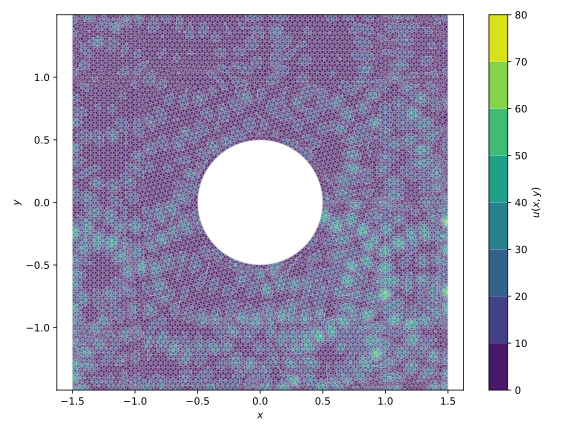

In [9]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, ezh_dic, type='abs')
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle1_EntireDomain.svg"))

## Figure 3: Meshed Physical Domain, $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pre_processing\pictures\meshed_physical_domain_Triangle1_EntireDomain.svg


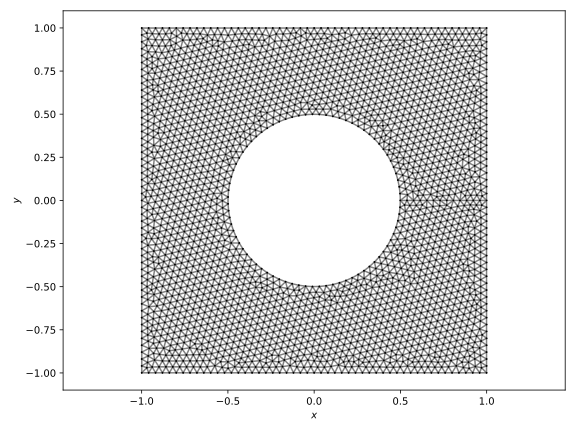

In [10]:
physical_mesh_data = ps.get_physical_mesh_data(mesh_data)
ps.plot_physical_mesh(FINITE_ELEMENT, mesh_data, physical_mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 4: Analytical Solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg


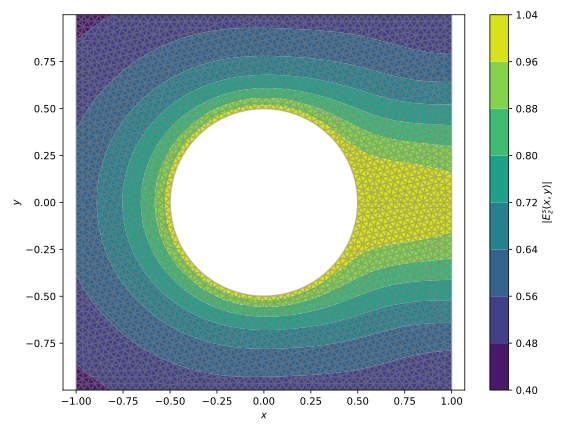

In [11]:
ez_phy = ps.solution_at_physical_domain(FINITE_ELEMENT, DOMAIN[DOMAIN_KEY], physical_mesh_data)
display(SVG(filename="pos_processing/pictures/analytical_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

## Figure 5: Numerical solution at $\Omega_{fs}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p33_circular_pec_scatterer_pml\pos_processing\pictures\fem_solution_at_physical_domain_Triangle1_EntireDomain.svg


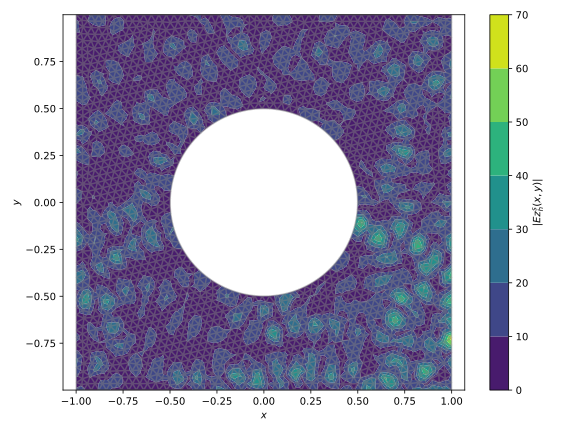

In [12]:
ezh_phy = ps.fem_solution_at_physical_domain(FINITE_ELEMENT, mesh_data, physical_mesh_data, ezh_dic)
display(SVG(filename="pos_processing/pictures/fem_solution_at_physical_domain_Triangle1_EntireDomain.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.